Minimal example of RelaxedBernoulliStraightThrough used in 1D Gaussian Mixture model, with custom guide based on AutoHierarchicalNormalMessenger.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoGuideList, AutoHierarchicalNormalMessenger, AutoLowRankMultivariateNormal
from pyro.infer.autoguide.utils import deep_getattr, deep_setattr
from pyro.nn.module import PyroParam
from torch.distributions import biject_to, constraints
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.infer import Predictive
from pyro.poutine import block
from tqdm.auto import tqdm

Add mean to RelaxedBernoulliStraightThrough to make it useable with Messenger guides:

In [2]:
from pyro.distributions import RelaxedBernoulliStraightThrough
RelaxedBernoulliStraightThrough.mean = property(lambda self: self.probs)

Produce some data from two Normal distributions with different means:

In [3]:
def generate_data(n_components = 2, n_observations = 100, ps = 0.9):
    
    mus = torch.tensor((4., 4.))
    b = pyro.sample('b', dist.Bernoulli(probs = ps).expand([n_observations]).to_event(1))
                             
    mean = mus[0] + mus[1]*b
    
    data = pyro.sample("data_target", dist.Normal(loc = mean, scale = 1.))
    
    return data, b

Samples are discrete during sampling:

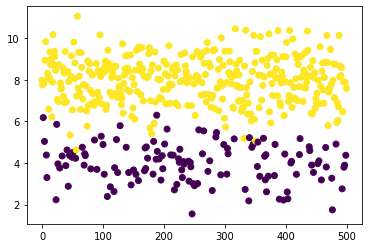

In [4]:
n_components = 2
n_observations = 500
ps = 0.75
data, b = generate_data(n_components, n_observations, ps)
plt.scatter(range(len(data)), data, c = b)

Our model using the Bernoulli distribution to assign observations to components:

In [5]:
def model(data, n_components, n_observations, i):
    
    ps = pyro.sample('ps', dist.Dirichlet(torch.ones(n_components) / 10.))
    mus = pyro.sample('mus', dist.Gamma(12, 2).expand([n_components]).to_event(1))
    b = pyro.sample(
        'b', 
        dist.Bernoulli(probs = ps[0]).expand([n_observations]).to_event(1),
        infer={"enumerate": "parallel"},
    )                    
    
    mean = mus[0] + mus[1]*b
    
    pyro.sample("data_target", dist.Normal(loc = mean, scale = torch.tensor(1.)).to_event(1), obs = data)

Define custom guide:

In [6]:
guide = AutoLowRankMultivariateNormal(poutine.block(model, hide=['b']))

Training:

In [7]:
# Train model:
n_iterations = 10000
optim = pyro.optim.Adam({'lr': 0.001})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, optim, loss=elbo)
elbos = []
for i in tqdm(range(n_iterations)):
    loss = svi.step(data, n_components, n_observations, i)
    elbos.append(loss)

posterior = Predictive(model, guide=guide, num_samples=1)(data, n_components, n_observations, i)

plt.plot(np.arange(1000, n_iterations, 1), elbos[1000:]);

  0%|          | 0/10000 [00:00<?, ?it/s]

NotImplementedError: Enumeration over cartesian product is not implemented
Trace Shapes:    
 Param Sites:    
Sample Sites:    
      ps dist | 2
        value | 2
     mus dist | 2
        value | 2

Evaluate model:

In [ ]:
print('Percentage correctly classified: ', np.array(torch.sum(b - posterior['b'] == 0)/len(b)))
b = torch.abs(b - 1)
print('Percentage correctly classified after switching categories: ', np.array(torch.sum(b - posterior['b'] == 0)/len(b)))
print('Percentage classified in category 1: ', np.array(torch.sum(b == 1)/len(b)))

In [ ]:
plt.scatter(range(len(data)), data, c = posterior['b'])

In [ ]:
posterior['mus'], posterior['ps']